In [ ]:
!pip install bayesian-optimization
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=3c811e12871e9e509a68e93d182e27f216ac2c49608e1f7f29acc9b522b61bd0
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import psutil
import GPUtil

from bayes_opt import BayesianOptimization

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cpu')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = np.load("/content/drive/MyDrive/Parkinson/X.npy")
y = np.load("/content/drive/MyDrive/Parkinson/y.npy")
y_multi_class = np.nan_to_num(np.load("/content/drive/MyDrive/Parkinson/y_multi_class.npy"))

X.shape, y.shape, y_multi_class.shape

((44021, 100, 19), (44021,), (44021,))

In [ ]:
# categorize the data
y_cat = np.eye(np.unique(y).shape[0], dtype='uint8')[y]
y_multi_class_cat = np.eye(np.unique(y_multi_class).shape[0], dtype='uint8')[np.asarray(y_multi_class, dtype='uint8')]

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (29494, 100, 19)
Shape of the validation set:  (7264, 100, 19)
Shape of the test set:  (7263, 100, 19)
Shape of the train set:  (29494, 2)
Shape of the validation set:  (7264, 2)
Shape of the test set:  (7263, 2)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train)).to(device)
X_val_tensors = Variable(torch.Tensor(X_val)).to(device)
X_test_tensors = Variable(torch.Tensor(X_test)).to(device)

y_train_tensors = Variable(torch.Tensor(y_train)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test)).to(device)
y_val_tensors = Variable(torch.Tensor(y_val)).to(device)

X_train_tensors.shape, X_val_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_val_tensors.shape, y_test_tensors.shape

(torch.Size([29494, 100, 19]),
 torch.Size([7264, 100, 19]),
 torch.Size([7263, 100, 19]),
 torch.Size([29494, 2]),
 torch.Size([7264, 2]),
 torch.Size([7263, 2]))

In [ ]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Define the function to calculate accuracy
def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = torch.eq(predicted, targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
class TimeTransformer(nn.Module):
    def __init__(self, input_dim, seq_length, num_heads, hidden_dim, num_layers, num_classes):
        super(TimeTransformer, self).__init__()

        # Transformer layers
        self.transformer_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(
            self.transformer_layers,
            num_layers=num_layers
        )

        # Output layer
        self.fc = nn.Linear(seq_length * input_dim, num_classes)

        self.counter = 0
        self.min_validation_loss = float('inf')

    def forward(self, x):
        # Pass through the transformer
        x = self.transformer(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layer for classification
        x = self.fc(x)

        return x

    def early_stop(self, validation_loss, min_delta, patience):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + min_delta):
          self.counter += 1
          if self.counter >= patience:
              return True
      return False

In [ ]:
def transformer_training(num_heads, hidden_dim, num_layers, learning_rate):
  model = TimeTransformer(19, 100, int(num_heads), int(hidden_dim), int(num_layers), 4).to(device)

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  best_acc = 0

  for epoch in range(100):
    model.train()  # Set the model to training mode
    for data in train_dataloader:
        inputs, labels = data

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      for data in val_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)

        batch_val_loss.append(val_loss.item())
        batch_val_acc.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))

      epoch_val_loss = np.average(batch_val_loss)

      val_accuracy = np.average(batch_val_acc)

    if best_acc < val_accuracy:
      best_acc = val_accuracy
    if model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break

  return best_acc

In [ ]:
def cma_es(objective_function, initial_solution, population_size=10, max_generations=10):

    """
    Algorithme CMA-ES pour l'optimisation continue

    Args:
        objective_function: Fonction objectif à minimiser
        initial_solution: Solution initiale
        population_size: Taille de la population
        max_generations: Nombre maximum de générations

    Returns:
        Meilleure solution trouvée
        Meilleure valeur de fitness
        Liste des meilleures valeurs de fitness à chaque génération
        Liste des solutions à chaque génération
    """

    # Définir la dimension du problème
    n = len(initial_solution)

    # Paramètres de l'algorithme CMA-ES
    sigma = 1.0  # Écart-type initial
    mu = population_size // 2  # Taille de la moitié de la population
    lambda_ = population_size  # Taille de la population

    # Listes pour stocker les résultats
    best_fitness_list = []
    current_solution = initial_solution
    current_sigma = sigma
    solution_list = []

    # Itérer sur les générations
    for generation in range(max_generations):

        # Générer une population de solutions candidates
        solutions = np.abs(np.random.multivariate_normal(current_solution, current_sigma**2 * np.identity(n), lambda_))

        # S'assurer que les solutions généré respectent les intervalles
        solutions[solutions[:, 0] < 1, 0] = 2 - solutions[solutions[:, 0] < 1, 0]

        solutions[solutions[:, 0] > 5, 0] = solutions[solutions[:, 0] > 5, 0] - (solutions[solutions[:, 0] > 5, 0] / 5).astype(int) * 5

        solutions[solutions[:, 1] < 128, 1] = 2 * 128 - solutions[solutions[:, 1] < 128, 1]

        solutions[solutions[:, 1] > 1024, 1] = solutions[solutions[:, 1] > 1024, 1] - (solutions[solutions[:, 1] > 1024, 1] / 1024).astype(int) * 1024

        solutions[solutions[:, 2] < 1, 2] = 2 - solutions[solutions[:, 2] < 1, 2]

        solutions[solutions[:, 2] > 5, 2] = solutions[solutions[:, 2] > 5, 2] - (solutions[solutions[:, 2] > 5, 2] / 5).astype(int) * 5

        solutions[solutions[:, 3] < 0.0001, 3] = 2 * 0.0001 - solutions[solutions[:, 3] < 0.0001, 3]

        solutions[solutions[:, 3] > 0.01, 3] = solutions[solutions[:, 3] > 0.01, 3] - (solutions[solutions[:, 3] > 0.01, 3] / 0.01).astype(int) * 0.01


        # Évaluer la fitness de chaque solution
        fitness_values = np.array([objective_function(sol) for sol in solutions])

        # Trier les solutions par fitness
        sorted_indices = (-fitness_values).argsort()
        solutions = solutions[sorted_indices]

        # Mettre à jour la moyenne des meilleures solutions
        new_mean = np.mean(solutions[:mu], axis=0)
        current_solution = new_mean

        # Mettre à jour l'écart-type
        z = solutions[:mu] - current_solution
        current_sigma = np.sqrt(np.sum(z**2) / mu)

        # Afficher la meilleure solution à chaque génération
        best_fitness = fitness_values[sorted_indices[0]]

        # Stocker les résultats
        best_fitness_list.append(best_fitness)
        solution_list.append(current_solution[0])

    return current_solution, best_fitness

In [ ]:
best_solution, best_fitness = cma_es(objective_function=transformer_training, initial_solution=[3, 128, 1, 0.001], population_size=10, max_generations=10)
print(f'num_heads = {int(best_solution[0])}, hidden_dim {int(best_solution[1])}, num_layers {int(best_solution[2])}, learning_rate {best_solution[3]:.4f}')
print(f'target = {best_fitness}')

num_heads = 1, hidden_dim 259, num_layers 2, learning_rate 0.0010
target = 0.9715


In [ ]:
# Define your model
input_dim = 19  # Dimension des caractéristiques pour chaque point temporel
seq_length = 100  # Longueur de la séquence temporelle
num_heads = best_solution[0]  # Nombre de têtes d'attention dans le transformer
hidden_dim = best_solution[1]  # Dimension de l'espace caché dans le transformer
num_layers = best_solution[2]  # Nombre de couches dans le transformer
num_classes = 2  # Nombre de classes pour la classification

model = TimeTransformer(input_dim, seq_length, num_heads, hidden_dim, num_layers, num_classes).to(device)

# Define the number of epochs and other parameters
num_epochs = 100
learning_rate = best_solution[3]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    total_loss = 0.0
    total_accuracy = 0.0
    with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
      for data in train_dataloader:
          inputs, labels = data

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute the loss
          loss = criterion(outputs, labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          # Update total loss
          total_loss += loss.item()

          # Compute accuracy for the current batch
          batch_accuracy = calculate_accuracy(outputs, torch.max(labels, 1)[1])
          total_accuracy += batch_accuracy

          pbar.update(1)

    # Average loss and accuracy over the entire training set
    average_loss = total_loss / len(train_dataloader)
    history["loss"].append(average_loss)
    average_accuracy = total_accuracy / len(train_dataloader)
    history["accuracy"].append(average_accuracy)

    model.eval()
    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
        for data in val_dataloader:
          inputs, labels = data
          outputs = model(inputs)
          val_loss = criterion(outputs, labels)

          batch_val_loss.append(val_loss.item())

          batch_val_acc.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))

          pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

    # Print statistics
    print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, average_loss, average_accuracy, epoch_val_loss, val_accuracy))
    print("----------------------------------------------------------------------------------------------")

    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(model.state_dict(), f"best_model.pth")
    if model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break


execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.49526, Accuracy: 0.77765, Val Loss: 0.38470, Val Accuracy: 0.84430
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.38503, Accuracy: 0.83963, Val Loss: 0.36270, Val Accuracy: 0.85256
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.31717, Accuracy: 0.87341, Val Loss: 0.25335, Val Accuracy: 0.90212
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.26820, Accuracy: 0.89502, Val Loss: 0.20450, Val Accuracy: 0.92318
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.22349, Accuracy: 0.91386, Val Loss: 0.19171, Val Accuracy: 0.92704
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.19044, Accuracy: 0.92708, Val Loss: 0.14939, Val Accuracy: 0.94576
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.16722, Accuracy: 0.93652, Val Loss: 0.14157, Val Accuracy: 0.94893
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.14646, Accuracy: 0.94538, Val Loss: 0.11797, Val Accuracy: 0.95677
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.12860, Accuracy: 0.95319, Val Loss: 0.09059, Val Accuracy: 0.96806
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.11789, Accuracy: 0.95758, Val Loss: 0.09793, Val Accuracy: 0.96586
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.10667, Accuracy: 0.96136, Val Loss: 0.09009, Val Accuracy: 0.96792
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.09556, Accuracy: 0.96556, Val Loss: 0.09483, Val Accuracy: 0.96751
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.09156, Accuracy: 0.96714, Val Loss: 0.11579, Val Accuracy: 0.95994
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.08483, Accuracy: 0.97036, Val Loss: 0.08766, Val Accuracy: 0.96806
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.07845, Accuracy: 0.97243, Val Loss: 0.09704, Val Accuracy: 0.96297
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.07468, Accuracy: 0.97236, Val Loss: 0.09561, Val Accuracy: 0.96985
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.07182, Accuracy: 0.97399, Val Loss: 0.06102, Val Accuracy: 0.98114
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.06694, Accuracy: 0.97651, Val Loss: 0.06439, Val Accuracy: 0.97756
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.06512, Accuracy: 0.97695, Val Loss: 0.06668, Val Accuracy: 0.97825
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.05957, Accuracy: 0.97795, Val Loss: 0.06635, Val Accuracy: 0.97605
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.05876, Accuracy: 0.97860, Val Loss: 0.08374, Val Accuracy: 0.97081
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.05789, Accuracy: 0.97882, Val Loss: 0.05952, Val Accuracy: 0.97839
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.05529, Accuracy: 0.97926, Val Loss: 0.06721, Val Accuracy: 0.97550
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.05171, Accuracy: 0.98092, Val Loss: 0.06989, Val Accuracy: 0.97701
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.05103, Accuracy: 0.98075, Val Loss: 0.07809, Val Accuracy: 0.97632
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.04675, Accuracy: 0.98231, Val Loss: 0.07271, Val Accuracy: 0.97770
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.04972, Accuracy: 0.98241, Val Loss: 0.05946, Val Accuracy: 0.97907
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.04661, Accuracy: 0.98378, Val Loss: 0.06623, Val Accuracy: 0.97907
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.04409, Accuracy: 0.98383, Val Loss: 0.05942, Val Accuracy: 0.98045
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.04000, Accuracy: 0.98458, Val Loss: 0.05854, Val Accuracy: 0.98224
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.04341, Accuracy: 0.98453, Val Loss: 0.06680, Val Accuracy: 0.97839
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.03981, Accuracy: 0.98560, Val Loss: 0.07005, Val Accuracy: 0.97825
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.04377, Accuracy: 0.98341, Val Loss: 0.04754, Val Accuracy: 0.98238
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.03829, Accuracy: 0.98610, Val Loss: 0.06886, Val Accuracy: 0.97673
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.03585, Accuracy: 0.98671, Val Loss: 0.07460, Val Accuracy: 0.98004
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.03558, Accuracy: 0.98715, Val Loss: 0.07384, Val Accuracy: 0.97687
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.03442, Accuracy: 0.98753, Val Loss: 0.05718, Val Accuracy: 0.98265
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.03354, Accuracy: 0.98799, Val Loss: 0.05586, Val Accuracy: 0.98265
----------------------------------------------------------------------------------------------


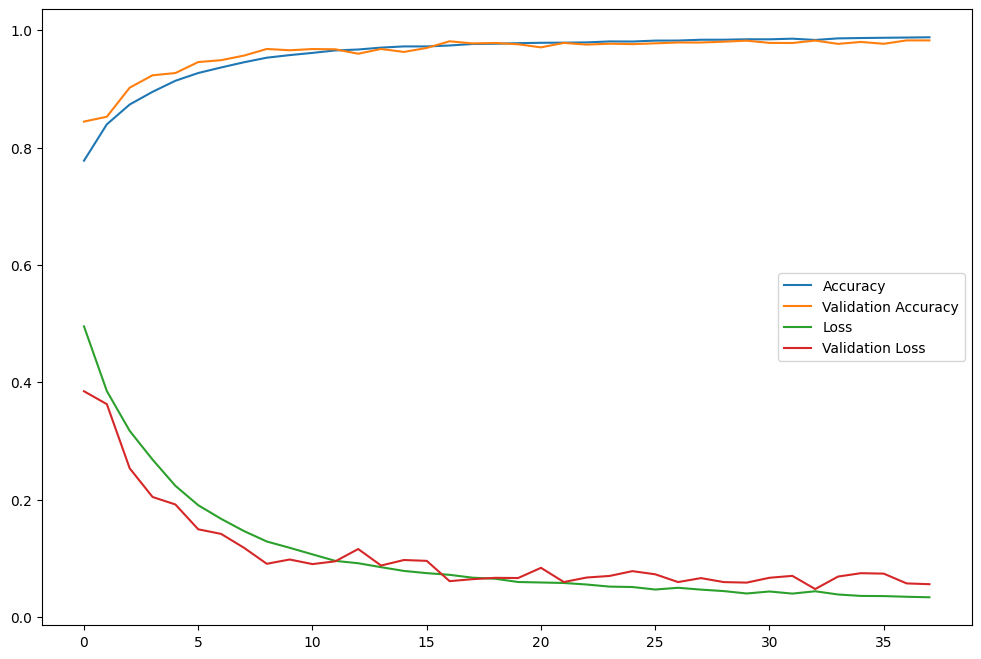

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
all_pred = []
all_labels = []

model.eval()  # Set the model to evaluation mode
m = nn.Softmax(dim=1)
with torch.no_grad():
    test_accuracy = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for data in test_dataloader:
          inputs, labels = data
          outputs = model(inputs)
          all_pred.extend(np.asarray(m(outputs)))
          all_labels.extend(torch.max(labels, 1)[1])
          test_accuracy.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))
          pbar.update(1)

all_labels = np.asarray([int(x) for x in all_labels])
predicted = np.argmax(all_pred, axis=1)

precision = precision_score(all_labels, predicted, average='weighted')
recall = recall_score(all_labels, predicted, average='weighted')
f1 = f1_score(all_labels, predicted, average='weighted')

cm = confusion_matrix(all_labels, predicted)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(all_labels, predicted, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.0559
Accuracy: 0.9807
Precision: 0.9807457161519999
Recall: 0.9807242186424343
F1 Score: 0.9807335893552271
TP: 7123
TN: 7123
FP: 140
FN: 140
AUC: 0.977972657202838
CPU Usage: 59.300000000000004%
Memory Usage: 0.6000000000000014%
Execution Time: 2094.7336616516113 seconds


Text(0.5, 1.0, 'Confusion Matrix')

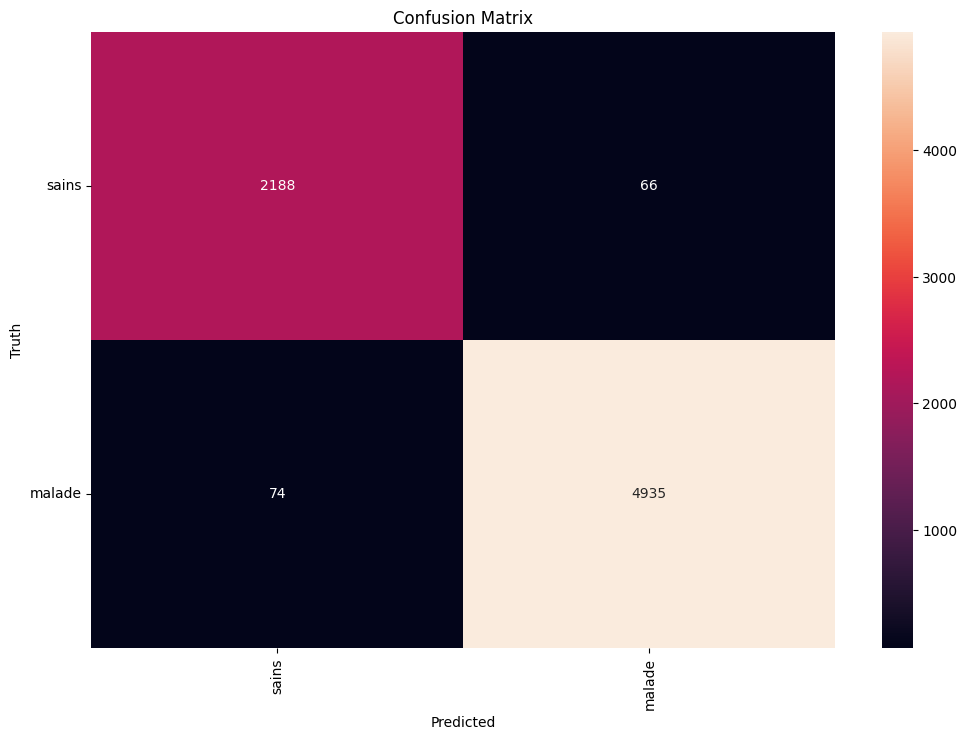

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(2)+0.5, ['sains', 'malade'], rotation=90)
plt.yticks(np.arange(2)+0.5, ['sains', 'malade'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

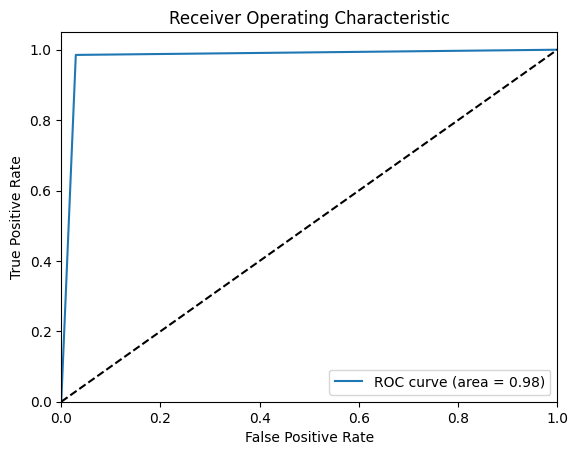

In [ ]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(all_labels, predicted)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Define your model
input_dim = 19  # Dimension des caractéristiques pour chaque point temporel
seq_length = 100  # Longueur de la séquence temporelle
num_heads = best_solution[0]  # Nombre de têtes d'attention dans le transformer
hidden_dim = best_solution[1]  # Dimension de l'espace caché dans le transformer
num_layers = best_solution[2]  # Nombre de couches dans le transformer
num_classes = 4  # Nombre de classes pour la classification

model = TimeTransformer(input_dim, seq_length, num_heads, hidden_dim, num_layers, num_classes).to(device)

# Define the number of epochs and other parameters
num_epochs = 100
learning_rate = best_solution[3]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    total_loss = 0.0
    total_accuracy = 0.0
    with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
      for data in train_dataloader:
          inputs, labels = data

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute the loss
          loss = criterion(outputs, labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          # Update total loss
          total_loss += loss.item()

          # Compute accuracy for the current batch
          batch_accuracy = calculate_accuracy(outputs, torch.max(labels, 1)[1])
          total_accuracy += batch_accuracy

          pbar.update(1)

    # Average loss and accuracy over the entire training set
    average_loss = total_loss / len(train_dataloader)
    history["loss"].append(average_loss)
    average_accuracy = total_accuracy / len(train_dataloader)
    history["accuracy"].append(average_accuracy)

    model.eval()
    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
        for data in val_dataloader:
          inputs, labels = data
          outputs = model(inputs)
          val_loss = criterion(outputs, labels)

          batch_val_loss.append(val_loss.item())

          batch_val_acc.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))

          pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

    # Print statistics
    print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, average_loss, average_accuracy, epoch_val_loss, val_accuracy))
    print("----------------------------------------------------------------------------------------------")

    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(model.state_dict(), f"best_model.pth")
    if model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break


execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.04243, Accuracy: 0.54336, Val Loss: 0.81703, Val Accuracy: 0.66423
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.70483, Accuracy: 0.71973, Val Loss: 0.54942, Val Accuracy: 0.79681
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.50859, Accuracy: 0.80518, Val Loss: 0.41926, Val Accuracy: 0.84898
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.39702, Accuracy: 0.85202, Val Loss: 0.35214, Val Accuracy: 0.87651
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.31326, Accuracy: 0.88590, Val Loss: 0.26318, Val Accuracy: 0.91300
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.26037, Accuracy: 0.90795, Val Loss: 0.21985, Val Accuracy: 0.92607
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.21390, Accuracy: 0.92591, Val Loss: 0.20394, Val Accuracy: 0.93626
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.18917, Accuracy: 0.93565, Val Loss: 0.20206, Val Accuracy: 0.93007
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.16805, Accuracy: 0.94360, Val Loss: 0.16110, Val Accuracy: 0.94425
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.15462, Accuracy: 0.94691, Val Loss: 0.14304, Val Accuracy: 0.95498
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.14306, Accuracy: 0.95235, Val Loss: 0.12285, Val Accuracy: 0.96077
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.13024, Accuracy: 0.95770, Val Loss: 0.11938, Val Accuracy: 0.96090
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.12635, Accuracy: 0.95655, Val Loss: 0.15138, Val Accuracy: 0.95113
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.11530, Accuracy: 0.96058, Val Loss: 0.10059, Val Accuracy: 0.96407
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.10724, Accuracy: 0.96292, Val Loss: 0.12250, Val Accuracy: 0.96173
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.10098, Accuracy: 0.96391, Val Loss: 0.11165, Val Accuracy: 0.96448
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.10052, Accuracy: 0.96446, Val Loss: 0.10248, Val Accuracy: 0.96311
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.09533, Accuracy: 0.96616, Val Loss: 0.10549, Val Accuracy: 0.96586
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.08541, Accuracy: 0.97024, Val Loss: 0.12537, Val Accuracy: 0.96228
----------------------------------------------------------------------------------------------


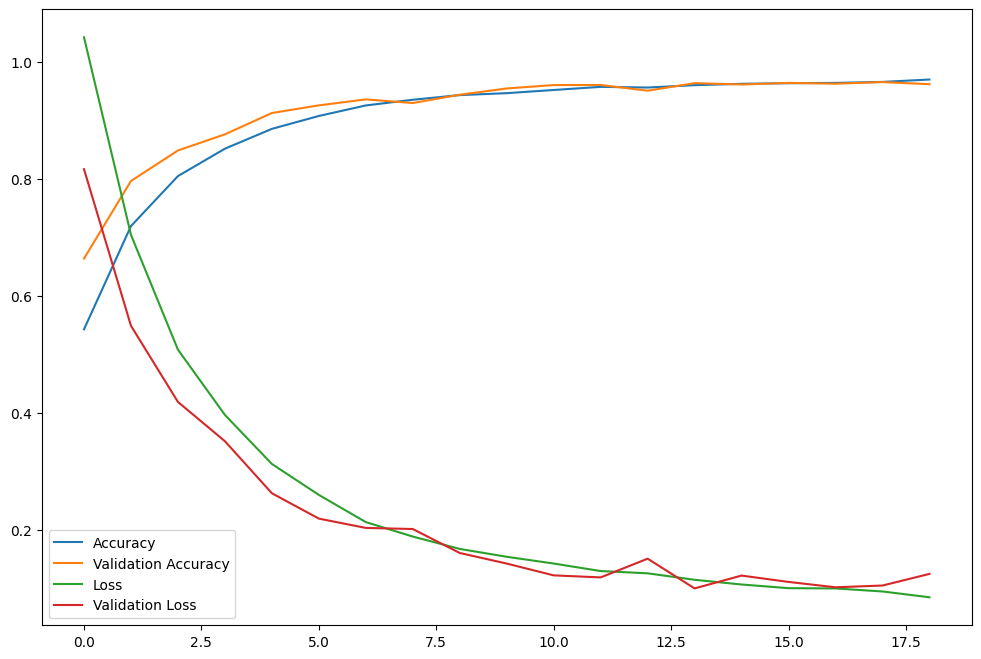

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
all_pred = []
all_labels = []

model.eval()  # Set the model to evaluation mode
m = nn.Softmax(dim=1)
with torch.no_grad():
    test_accuracy = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for data in test_dataloader:
          inputs, labels = data
          outputs = model(inputs)
          all_pred.extend(np.asarray(m(outputs)))
          all_labels.extend(torch.max(labels, 1)[1])
          test_accuracy.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))
          pbar.update(1)

all_labels = np.asarray([int(x) for x in all_labels])
predicted = np.argmax(all_pred, axis=1)

precision = precision_score(all_labels, predicted, average='weighted')
recall = recall_score(all_labels, predicted, average='weighted')
f1 = f1_score(all_labels, predicted, average='weighted')

cm = confusion_matrix(all_labels, predicted)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(all_labels, all_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1254
Accuracy: 0.9537
Precision: 0.9548602102546403
Recall: 0.9537381247418422
F1 Score: 0.9536549292658211
TP: 6927
TN: 21453
FP: 336
FN: 336
AUC: 0.997306950580107
CPU Usage: 12.399999999999999%
Memory Usage: 0.0%
Execution Time: 1061.23983502388 seconds


Text(0.5, 1.0, 'Confusion Matrix')

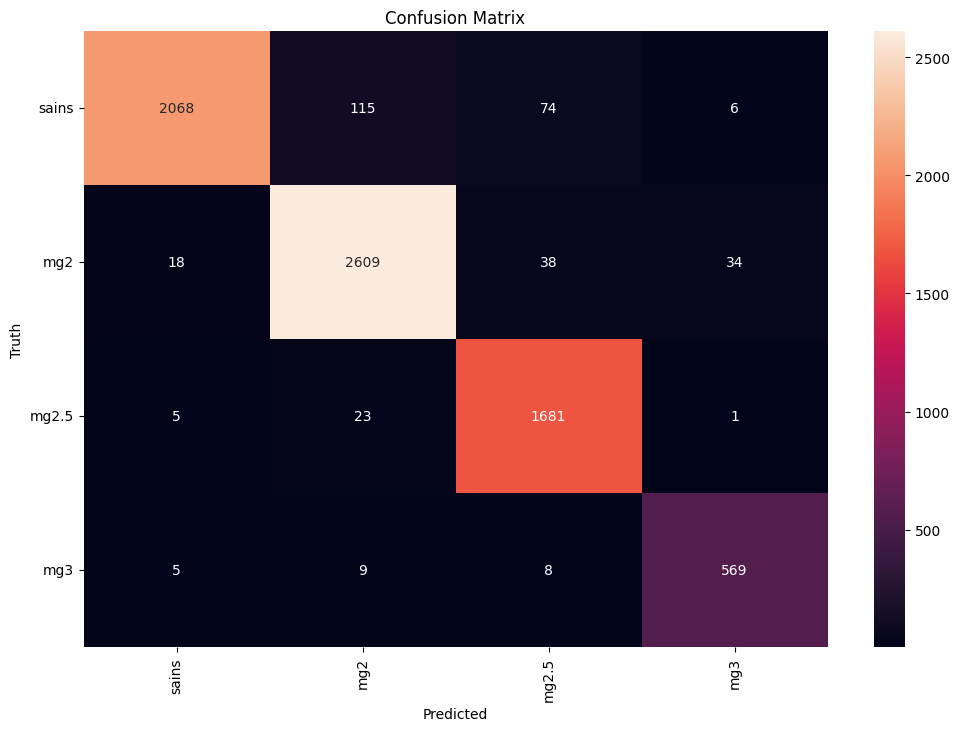

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=90)
plt.yticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

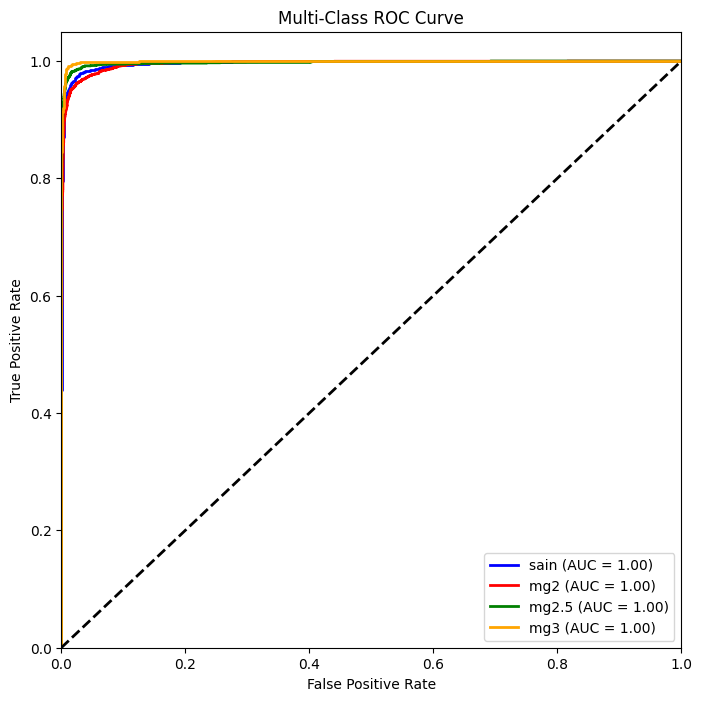

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_bin = label_binarize(all_labels, classes=np.unique(y_multi_class))

# Compute the predicted probabilities for each class
y_prob = np.asarray(all_pred)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_multi_class))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
classes = ['sain', 'mg2', 'mg2.5', 'mg3']
for i in range(len(np.unique(y_multi_class))):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='{0} (AUC = {1:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()